<a href="https://colab.research.google.com/github/sunohk/dataon_pj/blob/main/%ED%95%99%EC%8A%B5%EC%BD%94%EB%93%9C/1_sns_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1.패키지설치
- 환경설정: V100 GPU, 고용량 RAM, 시스템 RAM 4GB, GPU RAM 2GB



In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
! bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 31.93 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.1 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-10-18 00:19:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbu

In [ ]:
!pip install torch>=1.8.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter #리스트 원소들의 개수 파악
from sklearn.model_selection import train_test_split

##2.데이터불러오기

In [ ]:
df=pd.read_excel('./gdrive/MyDrive/01_공모전/2023_News/5_Presentation/제출자료/데이터/Processed_Data/1_youth_data.xlsx')

In [ ]:
df.head()

Date             User  \
0  2019/05/01  gyeongsangbukdo   
1  2019/05/01        dudtn1688   
2  2019/05/01     gabriela_ran   
3  2019/05/01          giguc31   
4  2019/05/01         sisa2007   

                                            Contents Type  \
0  #공예업체 _취업을 원하는 \n경북의 취준생들에게 꿀 정보??\n#경상북도 #청년정...  트위터   
1  안녕하세요! \n처음 여러분들에게 인사를 드리네요. \n이번 '2019 NCS 청년...  블로그   
2  \n \n(서로의 동거인이 된 하요와 함께 찍은 사진) \n \n__ \n \n2월...  블로그   
3  안녕하세요! 청춘 너나들이 서포터즈 권성빈입니다. \n청춘 너나들이에서 청년들의 취...  블로그   
4  \n﻿유승희 국회의원, 청년문제 돌파구 찾는다! \n고려대서 정책 토크콘서트 “기본...  블로그   

                                             Summary Topic  
0      공예 업체 취업 경북 취 준 정보 경상북도 청년 정책 일자리 정책 취업 지원 사업  청년정책  
1     청년 서포터 즈           청년 서포터 즈 발대식 을 다녀오 다   안...  청년정책  
2  감사 한 나날 서로 동거인 하 요 사진 일자 퇴사 완주 내 완주 생각 완주 달 몽골...  청년정책  
3    청년 정책 멘토링   내 가 도움 받 을 수 있 는 정책 은 무엇 일까   안녕...  청년정책  
4        유승희 국회의원   청년 문제 돌파구 찾 는다   유승희 국회의원 청년 ...  청년정책

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53855 entries, 0 to 53854
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      53855 non-null  object
 1   User      53855 non-null  object
 2   Contents  53855 non-null  object
 3   Type      53855 non-null  object
 4   Summary   53855 non-null  object
 5   Topic     53855 non-null  object
dtypes: object(6)
memory usage: 2.5+ MB


##3.모델링불러오기

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

In [ ]:
# 모델 로드
model_path = '# 모델 파일의 경로/1_kobert_model.pt'

# Torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

In [ ]:
# 모델 아키텍처를 생성
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=2)  # num_labels는 분류 클래스 수에 따라 설정
model.to(device)
model.eval()

In [ ]:
# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")

In [ ]:
def perform_sentiment_analysis(text):
    encoded_text = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}
    with torch.no_grad():
        output = model(**encoded_text)
    logits = output.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

In [ ]:
# "clean_contents" 컬럼에 대한 감성 분석 수행 및 결과 저장
df['감성분석'] = df['Summary'].apply(perform_sentiment_analysis)
df.head()

Date             User  \
0  2019/05/01  gyeongsangbukdo   
1  2019/05/01        dudtn1688   
2  2019/05/01     gabriela_ran   
3  2019/05/01          giguc31   
4  2019/05/01         sisa2007   

                                            Contents Type  \
0  #공예업체 _취업을 원하는 \n경북의 취준생들에게 꿀 정보??\n#경상북도 #청년정...  트위터   
1  안녕하세요! \n처음 여러분들에게 인사를 드리네요. \n이번 '2019 NCS 청년...  블로그   
2  \n \n(서로의 동거인이 된 하요와 함께 찍은 사진) \n \n__ \n \n2월...  블로그   
3  안녕하세요! 청춘 너나들이 서포터즈 권성빈입니다. \n청춘 너나들이에서 청년들의 취...  블로그   
4  \n﻿유승희 국회의원, 청년문제 돌파구 찾는다! \n고려대서 정책 토크콘서트 “기본...  블로그   

                                             Summary Topic  감성분석  
0      공예 업체 취업 경북 취 준 정보 경상북도 청년 정책 일자리 정책 취업 지원 사업  청년정책     1  
1     청년 서포터 즈           청년 서포터 즈 발대식 을 다녀오 다   안...  청년정책     1  
2  감사 한 나날 서로 동거인 하 요 사진 일자 퇴사 완주 내 완주 생각 완주 달 몽골...  청년정책     1  
3    청년 정책 멘토링   내 가 도움 받 을 수 있 는 정책 은 무엇 일까   안녕...  청년정책     1  
4        유승희 국회의원   청년 문제 돌파구 찾 는다   유승희 국회의원 청년 ...  청년정책     1

<Axes: >

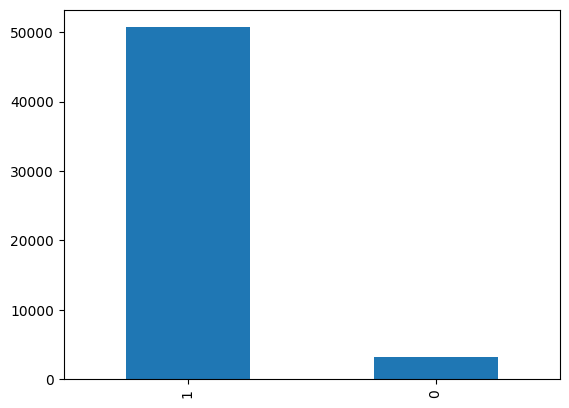

In [ ]:
df['감성분석'].value_counts().plot(kind='bar')

In [ ]:
output_file_path = './gdrive/MyDrive/finalproject/datasets/youth.xlsx'  # 결과를 저장할 경로와 파일 이름
df.to_excel(output_file_path, index=False)